# Use FastAI image classifier on over sampled images

Here is my attempt to apply learning of fastai v3 course at humpback whale competition. Along with that i am borrowing codes from 'https://github.com/radekosmulski/whale/'. Big thanks to him for creating such an awesome repository to get a good starting point in this competition 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
#from skimage.util import montage
import pandas as pd
from torch import optim
import re


import numpy as np
import torch
import pandas as pd
import os 
import sys


In [2]:
import fastai
from fastprogress import force_console_behavior
import fastprogress
fastprogress.fastprogress.NO_BAR = True
master_bar, progress_bar = force_console_behavior()
fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

In [3]:
def top_5_pred_labels(preds, classes):
    top_5 = top_5_preds(preds)
    labels = []
    for i in range(top_5.shape[0]):
        labels.append(' '.join([classes[idx] for idx in top_5[i]]))
    return labels

def create_submission(preds, data, name, classes=None):
    if not classes: classes = data.classes
    sub = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
    sub['Id'] = top_5_pred_labels(preds, classes)
    sub.to_csv(f'data/whale/subs/{name}.csv' , index = False)
    #sub.to_csv(f'subs/{name}.csv.gz', index=False, compression='gzip')
                                                                        


In [4]:
df = pd.read_csv('data/whale/train.csv')
freq_whale_ids = df.Id.value_counts().reset_index()

In [5]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)


In [6]:
name = f'res50-full-train'

In [7]:
"""
created an oversampled data set as suggested by radek
"""
oversampled_data = pd.read_csv('data/whale/oversampled_with_val.csv')

In [8]:
SZ = 224*2
BS = 64 // 4
SEED=0
NUM_WORKERS = 8
val_fns = {'69823499d.jpg'}

In [9]:
data = (
    ImageItemList
        .from_df(oversampled_data, 'data/whale/train', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder('data/whale/test'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

In [10]:
from utils import *
learn = create_cnn(data , models.resnet50 , lin_ftrs=[2048] , metrics = [accuracy , map5])
learn.clip_grad();

"""
    I have tried progressive resizing of input images as suggested in fast ai . 
    Firstly i will train resnet 50 on original input data set on size 128 X 128 (after unfreezing around 20 epochs). 
    Then load oversamopled data set , train for 2-3 epochs before unfreezing and 4-5 epochs after unfreezing. We can observe
    that the training loss on this new data set quickly reaches to the final loss on original data (wo oversampling). We can save 
    this model now. 
    
    Then use this model as pretrained model and train it on input images 224 X 224. Firstly on original dataset (20 epochs) and later on 
    oversampled data set (5 epochs).
    
    Finally use above pretrained model for size 448X448. It will become harder to train as we increase size of images , we need to 
    reduce batch size to take care of memory issues as well.


"""
learn.load(f'{name}-stage-4');

In [11]:
learn.lr_find()

epoch     train_loss  valid_loss  accuracy  map5    
1         1.952453                
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


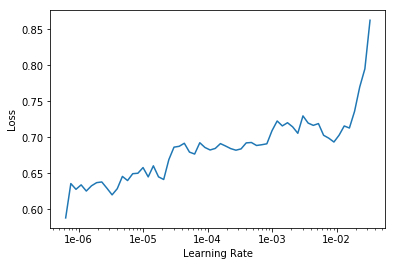

In [12]:
learn.recorder.plot()

We should take some where around 10 times lesser than 1e-2 as LR but because of difficulty in training a data set with more number of images , i am trying to use 4 time smaller learning rate.

epoch     train_loss  valid_loss  accuracy  map5    
1         1.719182    0.000006    1.000000  1.000000  
2         0.581418    0.000197    1.000000  1.000000  
epoch     train_loss  valid_loss  accuracy  map5    
1         1.351919                
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
epoch     train_loss  valid_loss  accuracy  map5    
1         0.560741    0.000752    1.000000  1.000000  
2         0.594290    0.000028    1.000000  1.000000  
3         0.447626    0.000133    1.000000  1.000000  


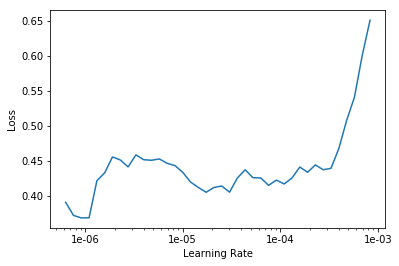

In [13]:
learn.freeze_to(-1)
learn.fit_one_cycle(2, 1e-2 / 4)

learn.unfreeze()

learn.lr_find()
learn.recorder.plot()


max_lr = 1e-3 / 4
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(3, lrs)

In [14]:
learn.save(f'{name}-trained_full_oversampled_images');

In [15]:
learn.fit_one_cycle(4, lrs)

epoch     train_loss  valid_loss  accuracy  map5    
1         0.807211    0.000345    1.000000  1.000000  
2         1.346154    0.005296    1.000000  1.000000  
3         1.556103    0.001041    1.000000  1.000000  
4         1.514041    0.003757    1.000000  1.000000  


In [16]:

preds, _ = learn.get_preds(DatasetType.Test)
preds = torch.cat((preds, torch.ones_like(preds[:, :1])), 1)

preds[: , 5004] = 0.06

classes = learn.data.classes + ['new_whale']


In [17]:
name = 'whale_only_oversampled_resnet50_v5'
create_submission(preds, learn.data, name, classes)

In [18]:
## average number of rows with new whale as their first prediction
pd.read_csv(f'data/whale/subs/{name}.csv').Id.str.split().apply(lambda x: x[0] == 'new_whale').mean()

0.660929648241206

In [19]:
"""
Achieving a leaderboard score of 0.786 with above method
"""
! kaggle competitions submit -c humpback-whale-identification -f data/whale/subs/{name}.csv -m "more trained on oversample full data"

100%|█████████████████████████████████████████| 498k/498k [00:04<00:00, 105kB/s]
Successfully submitted to Humpback Whale Identification